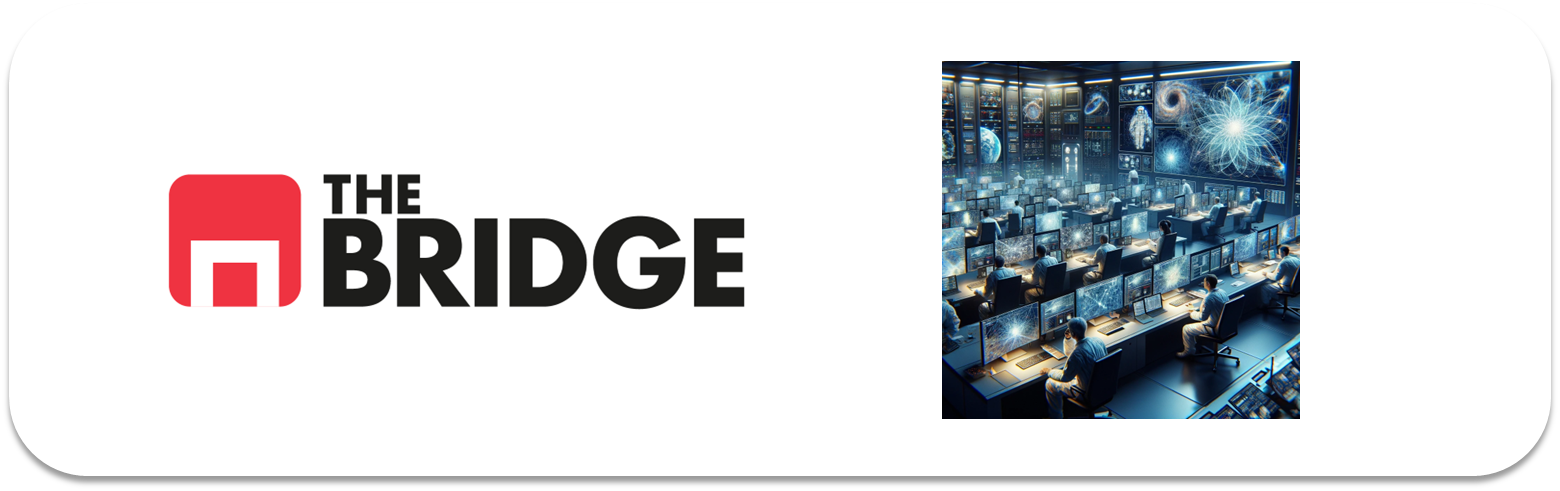

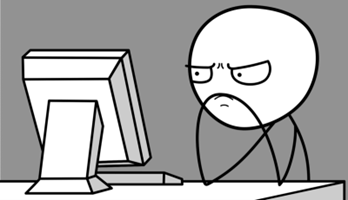

Para ejercitarte y afianzar lo aprendido sobre **Transfer Learning y Fine-tuning**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import numpy as np

## Apple 360

En este conjunto de ejercicios vas a montar un clasificador de manzanas mediante un dataset de imágenes. El dataset se compone de 13 tipos diferentes con aproximadamente unas 200 imágenes por cada tipo. Tendrás que montar un modelo de deep learning que utilice **transfer learning**. Se sugiere empezar con una red ResNet50 con imagenet.

El dataset original proviene del [concurso de Kaggle Fruits 360](https://www.kaggle.com/moltean/fruits), pero adaptado para la clasificación de una menor cantidad de casos (sólo las manzanas).


### Ejercicio 1

Crea los juegos de X,y para train y test a partir de los datos teninendo en cuenta su distribución, para ello tendrás que explorar las estructura. Crea un juego Train,test para resolución 32x32 y un juego de test adicional para 224x224. Es decir tendras que tener un X_train, X_test para 32x32 y un X_test adicional a 224x224

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio donde se encuentran las imágenes de manzanas
DATASET_PATH = "./data/apples" 

# Parámetros
IMG_SIZE_SMALL = (32, 32)
IMG_SIZE_LARGE = (224, 224)
BATCH_SIZE = 32

# Definir los generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalización
test_datagen = ImageDataGenerator(rescale=1./255)  

# Directorios de imágenes
train_dir = "data/apples/train"
test_dir = "data/apples/test"

# Tamaño de imagen 32x32
image_size = (32, 32)
batch_size = 32  # Puedes ajustar según la memoria disponible

# Generadores de imágenes
train_generator_32 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",  # Asegura que la salida sea one-hot encoding
    shuffle=True
)

test_generator_32 = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No mezclamos test para evaluación clara
)


# Obtener X_train, y_train de train_generator_32
X_train, y_train = next(train_generator_32)
X_test_32, y_test_32 = next(test_generator_32)

# Verificar dimensiones
print(f"X_train shape: {X_train.shape}")
print(f"X_test_32 shape: {X_test_32.shape}")


Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.
X_train shape: (32, 32, 32, 3)
X_test_32 shape: (32, 32, 32, 3)


**NOTA:** A partir de aquí emplea siempre el X_train, X_test de 32x32 salvo en el ejercicio que se te diga lo contrario.

### Ejercicio 2

Haz una visualización de algunos de los datos. Crea una función que te ayude con ello.

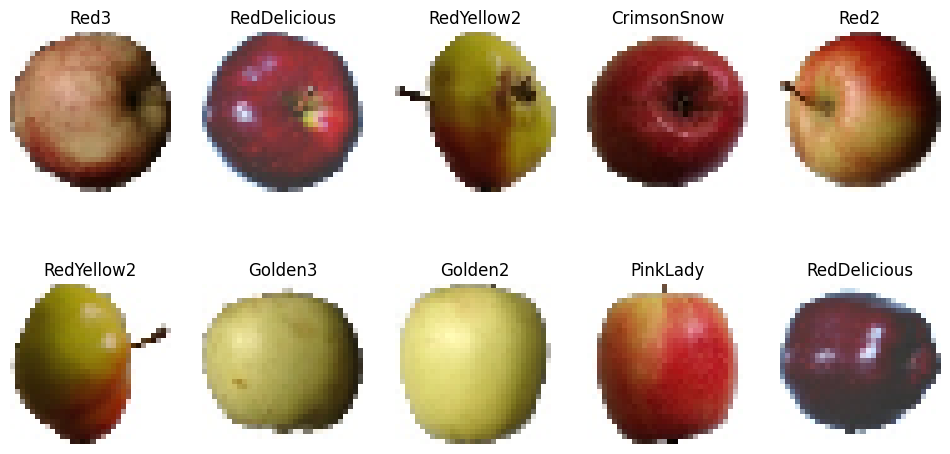

In [28]:
import matplotlib.pyplot as plt

def visualizar_imagenes(X, y, class_labels, num_images=10):
    """
    Muestra una serie de imágenes con sus etiquetas.

    Parámetros:
    - X: array de imágenes.
    - y: etiquetas en one-hot encoding.
    - class_labels: lista de nombres de las clases.
    - num_images: cantidad de imágenes a mostrar.
    """
    plt.figure(figsize=(12, 6))
    indices = np.random.choice(len(X), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[idx])
        plt.title(class_labels[np.argmax(y[idx])])
        plt.axis("off")

    plt.show()

# Obtener etiquetas de las clases
class_labels = list(train_generator_32.class_indices.keys())

# Visualizar imágenes del conjunto de entrenamiento
visualizar_imagenes(X_train, y_train, class_labels)


### Ejercicio 3

Completa el miniEDA habitual con imágenes y escoge una métrica para el modelo.

/var/folders/lc/xsbjt6rs2gq59y6tqrhdjzb40000gn/T/ipykernel_13750/3612473253.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Clase", y="Cantidad", data=class_distribution, palette="viridis")


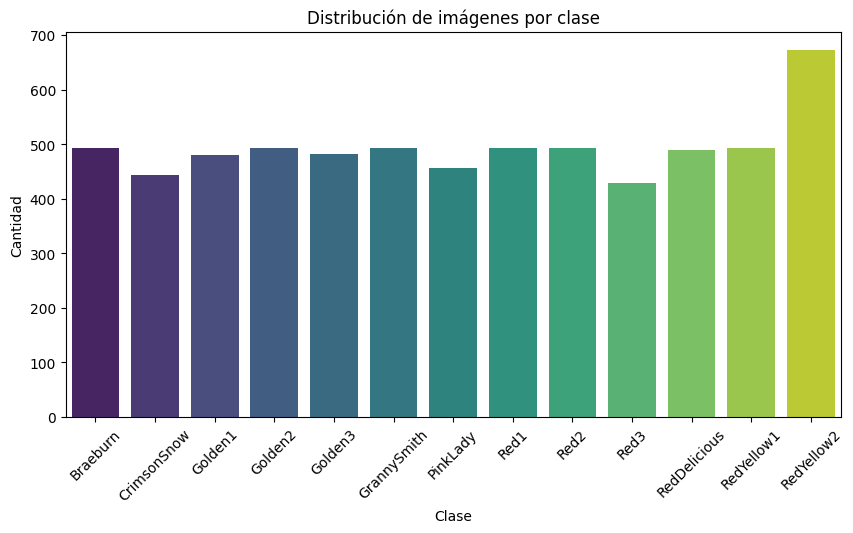

Total imágenes en Train: 6404
Total imágenes en Test: 2134


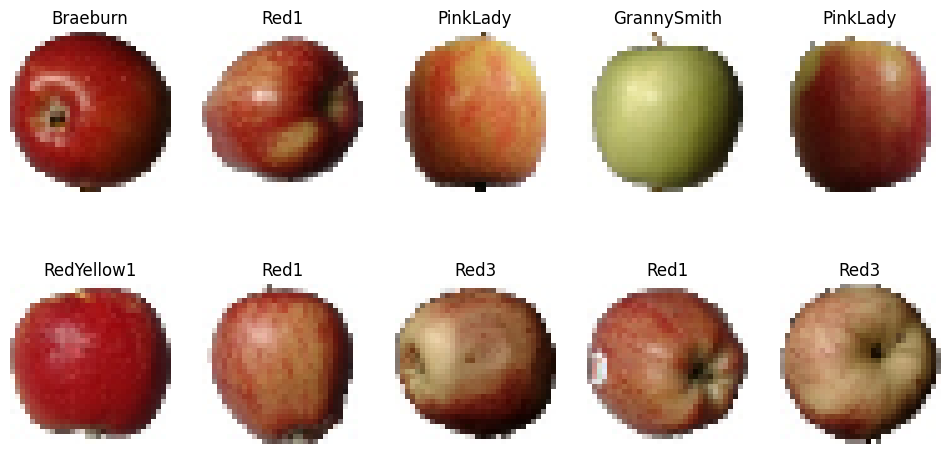

In [6]:
import seaborn as sns

# Obtener el número de imágenes por clase
class_counts = {k: v for k, v in train_generator_32.class_indices.items()}
class_distribution = pd.DataFrame({
    "Clase": list(class_counts.keys()),
    "Cantidad": [train_generator_32.classes.tolist().count(v) for v in class_counts.values()]
})

# 📊 1. Distribución de clases
plt.figure(figsize=(10, 5))
sns.barplot(x="Clase", y="Cantidad", data=class_distribution, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribución de imágenes por clase")
plt.show()

# 📌 2. Estadísticas básicas
print(f"Total imágenes en Train: {train_generator_32.samples}")
print(f"Total imágenes en Test: {test_generator_32.samples}")

# 📸 3. Visualización de imágenes (usando la función anterior)
visualizar_imagenes(X_train, y_train, class_labels)


### Ejercicio 4 

Termina de transformar los datos si crees que es conveniente y aunque el entrenamiento de modelos de keras ya tiene un shuffling interno, haz un "barajado" del X_train (del X_test no es necesario) para facilitar la convergencia inicial del modelo. Utiliza la función shuffle de sklearn y asigna la salida a un X_train distinto (es decir no machaques el inicial)

In [11]:
from sklearn.utils import shuffle

# Barajar X_train y y_train sin modificar los originales
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

# Verificar que se barajaron correctamente
print("Datos barajados correctamente.")


Datos barajados correctamente.


### Ejercicio 5

Sklearn permite trabajar con etiquetas textuales pero keras no. Transforma las etiquetas a numéricas, creando dos diccionarios uno que permita traducir de etiqueta a clase numérica y otro que permita la transformación inversa.

In [12]:
# Obtener el mapeo de clases detectadas por ImageDataGenerator
label_to_index = train_generator_32.class_indices  # {'Fuji': 0, 'Gala': 1, 'Golden': 2, ...}

# Crear el diccionario inverso para convertir de número a texto
index_to_label = {v: k for k, v in label_to_index.items()}

# Verificar que los diccionarios son correctos
print("Diccionario de etiquetas a números:", label_to_index)
print("Diccionario inverso (números a etiquetas):", index_to_label)


Diccionario de etiquetas a números: {'Braeburn': 0, 'CrimsonSnow': 1, 'Golden1': 2, 'Golden2': 3, 'Golden3': 4, 'GrannySmith': 5, 'PinkLady': 6, 'Red1': 7, 'Red2': 8, 'Red3': 9, 'RedDelicious': 10, 'RedYellow1': 11, 'RedYellow2': 12}
Diccionario inverso (números a etiquetas): {0: 'Braeburn', 1: 'CrimsonSnow', 2: 'Golden1', 3: 'Golden2', 4: 'Golden3', 5: 'GrannySmith', 6: 'PinkLady', 7: 'Red1', 8: 'Red2', 9: 'Red3', 10: 'RedDelicious', 11: 'RedYellow1', 12: 'RedYellow2'}


### Ejercicio 6: Zero Shot Learning

Descar el modelo ResNet50 preparado ya para poder usarlo directamente a la Zero Shot Learning. Pruébalo contra el test (aquí no valen nuestras categorías serán las que proporcione ResNet ojo). Prueba una selección aleatoria de imágenes del test y compara las etiquetas de ResNet con la que tiene. ¿Nos sirve este clasificador así tal cual?

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import random
import matplotlib.pyplot as plt

# Cargar el modelo ResNet50 con pesos de ImageNet
resnet_model = ResNet50(weights="imagenet")


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [16]:
def predecir_con_resnet(img_path):
    """
    Carga una imagen, la procesa para ResNet50 y obtiene las predicciones del modelo.
    """
    # Cargar imagen y ajustar tamaño a 224x224 para ResNet
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expandir dimensiones para el modelo
    img_array = preprocess_input(img_array)  # Preprocesamiento para ResNet

    # Hacer la predicción
    preds = resnet_model.predict(img_array)

    # Decodificar las 3 predicciones más probables
    decoded_preds = decode_predictions(preds, top=3)[0]
    
    return img, decoded_preds


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1. maraca (27.85%)
2. punching_bag (17.10%)
3. gong (9.89%)


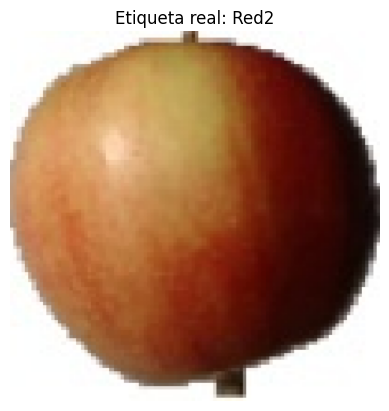

In [ ]:

# Obtener imágenes aleatorias del test
test_dir = "./data/apples/test"
random_class = random.choice(os.listdir(test_dir))  # Elegimos una variedad de manzana aleatoria
random_image = random.choice(os.listdir(os.path.join(test_dir, random_class)))  # Elegimos una imagen

# Obtener ruta completa de la imagen
img_path = os.path.join(test_dir, random_class, random_image)

# Predecir con ResNet
img, preds = predecir_con_resnet(img_path)

# Mostrar la imagen con las predicciones
plt.imshow(img)
plt.axis("off")
plt.title(f"Etiqueta real: {random_class}")

# Mostrar las predicciones de ResNet
for i, (imagenet_id, label, prob) in enumerate(preds):
    print(f"{i+1}. {label} ({prob:.2%})")


## Transfer Learning

### Ejercicio 7:

Carga la ResNet50 sin cabezas, crea un modelo con el anterior y una cabeza con dos capas densas, una oculta de 300 unidades (con activación "relu") y otra de salida con las unidades que crees necesarias y activación la que consideres. Congela las capas del modelo base (la ResNet50). Define también los hiperparámetros necesarios para compilar y compila el modelo y muestra un summary del mismo.

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargar ResNet50 sin la cabeza
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas de la base (ResNet50)
for layer in base_model.layers:
    layer.trainable = False

# Añadir la cabeza personalizada
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Capa de pooling global para reducir las dimensiones
x = Dense(300, activation='relu')(x)  # Capa densa oculta con 300 unidades y activación ReLU
x = Dense(len(class_labels), activation='softmax')(x)  # Capa de salida con el número de clases y activación softmax

# Definir el modelo completo
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),  # Optimización con Adam y una tasa de aprendizaje pequeña
              loss='categorical_crossentropy',  # Para clasificación múltiple, usamos categorical crossentropy
              metrics=['accuracy'])  # Métrica de precisión

# Mostrar el resumen del modelo
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,206,325 (92.34 MB)

 Trainable params: 618,613 (2.36 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Ejercicio 8

Entrena el modelo con nuestros datos de train y muestra la evolución del entrenamiento. Emplea un callback de Earlystopping con patience a 5. Termina de escoger el batch_size y el número de épocas.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Definir los generadores con imágenes redimensionadas a 224x224
train_generator_224 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Asegúrate de usar 224x224
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_generator_224 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Asegúrate de usar 224x224
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Cargar ResNet50 sin las cabezas finales
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base
base_model.trainable = False

# Añadir nuevas capas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(300, activation='relu')(x)
x = Dense(len(class_labels), activation='softmax')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurar parámetros
batch_size = 32  
epochs = 50  

# Callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  
                               restore_best_weights=True, 
                               verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator_224,  
    epochs=epochs,
    validation_data=test_generator_224,  
    callbacks=[early_stopping],
)

# Mostrar la evolución del entrenamiento (precisión y pérdida)
plt.figure(figsize=(12, 5))

# Gráfico de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.
Epoch 1/50
 45/201 ━━━━━━━━━━━━━━━━━━━━ 2:29 958ms/step - accuracy: 0.0824 - loss: 2.6703

KeyboardInterrupt: 

In [21]:
# Tamaño de imagen 224x224
image_size = IMG_SIZE_LARGE  # Cambia a 224x224

# Generadores de imágenes con tamaño 224x224
train_generator_224 = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,  # Cambia aquí el tamaño de la imagen
    batch_size=batch_size,
    class_mode="categorical",  # Asegura que la salida sea one-hot encoding
    shuffle=True
)

test_generator_224 = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,  # Cambia aquí el tamaño de la imagen
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False  # No mezclamos test para evaluación clara
)


Found 6404 images belonging to 13 classes.
Found 2134 images belonging to 13 classes.


### Ejercicio 9

Evalua el modelo contra test y haz un pequeño análisis de las diferencias. Haz un clasification report y muestra la matriz de confusion. Haz un pequeño análisis de errores.

## Fine Tuning

### Ejercicio 10

Vuelve a descargar el modelo ResNet50 pero sin pesos entrenados, ni cabeza, crea el mismo modelo personalizado que en el ejercicio 7, compila y muestra el summary.

### Ejercicio 11
Entrena con batch_size a 64 y 60 épocas, con un EarlyStopping de patience a 10 (ahora el entrenamiento es sensiblemente más largo, así que tómate un descanso). Muestra la evolución y da una posible justificación a emplear tantas épocas de partida.

### Ejercicio 12

Muestra la evaluación contra el test, el informe de clasificación  y la matriz de confusión. Compara los resultados con los del ejercicio 9.